In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import imgaug.augmenters as iaa

In [2]:
# Set TensorFlow to utilize GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# The rest of your code remains unchanged...

def create_coin_vocabulary_key_desc(image_dir, num_samples_per_coin=50):
    coin_vocabulary = {}
    # Step 1: Collect a dataset of images containing different Euro coins
    coin_directories = os.listdir(image_dir)

    for coin_dir in coin_directories:
        coin_path = os.path.join(image_dir, coin_dir)
        if not os.path.isdir(coin_path):
            continue
        print(f'Processing {coin_dir}...')
        # Randomly select images from each coin directory
        coin_images = os.listdir(coin_path)
        print(coin_dir, len(coin_images))
        selected_images = np.random.choice(coin_images, min(num_samples_per_coin, len(coin_images)), replace=False)

        # Add selected images to the vocabulary
        coin_vocabulary[coin_dir] = [os.path.join(coin_path, image_name) for image_name in selected_images]
        # print(coin_dir )
        # for i in coin_vocabulary[coin_dir]:
        #     print(i)
    return coin_vocabulary


# Train Model for finding best matching coin

In [3]:


# Define augmentation pipeline
augmentation_pipeline = iaa.Sequential([
    iaa.Rotate((-180, 180)),          # Rotate images by -10 to 10 degrees
    iaa.Fliplr(0.5),                # Flip images horizontally with 50% probability
    iaa.Multiply((0.8, 1.2)),       # Multiply pixel values by a random value between 0.8 and 1.2
    iaa.ContrastNormalization((0.8, 1.2)),  # Normalize contrast
    iaa.Crop(px=(0, 16)),           # Crop images by up to 16 pixels
])

def augment_image(image, augmentation_pipeline):
    return augmentation_pipeline(images=[image]*1)[0]

# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Parameters
input_shape = (400, 400, 3)  # Example input shape, adjust according to your images
num_samples_per_coin = 20
augment_count = 5
image_dir = "trainset_no_bg"
# Create coin vocabulary
coin_vocabulary = create_coin_vocabulary_key_desc(image_dir, num_samples_per_coin)
coin_classes = list(coin_vocabulary.keys())

# Create dataset
dataset_images = []
for class_name, images in coin_vocabulary.items():
    for image_path in images:
        # img = tf.keras.preprocessing.image.load_img(image_path, target_size=(input_shape[0], input_shape[0]))
        img = cv2.imread(image_path)
        if img.size == 0:
            print(f'Error loading image: {image_path}')
            continue
        img = cv2.resize(img, (input_shape[0], input_shape[1]))
        
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
        augment_count = num_samples_per_coin - len(images)
        for _ in range(augment_count):
            augmented_img_array = augment_image(img_array, augmentation_pipeline)
            dataset_images.append((class_name, augmented_img_array))
        dataset_images.append((class_name, img_array))

print(f'Total number of images: {len(dataset_images)}')
# Shuffle dataset
np.random.shuffle(dataset_images)

# Split dataset into training and validation sets
split_idx = int(len(dataset_images) * 0.8)
train_data = dataset_images[:split_idx]
validation_data = dataset_images[split_idx:]

# Define data generators
labels_dict = {class_name: i for i, class_name in enumerate(coin_classes)}
def data_generator(data, batch_size=32):
    while True:
        batch_indices = np.random.choice(len(data), batch_size, replace=False)
        images = []
        labels = []
        for idx in batch_indices:
            class_name, image = data[idx]
            images.append(image)
            labels.append(labels_dict[class_name])
        yield np.array(images), tf.keras.utils.to_categorical(labels, num_classes=len(coin_classes))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# Create CNN model
num_classes = len(coin_classes)  # Number of coin classes
model = create_cnn_model(input_shape, num_classes)

# Train the model
history = model.fit(
    data_generator(train_data),
    steps_per_epoch=len(train_data) // 32,
    epochs=100,
    validation_data=data_generator(validation_data),
    validation_steps=len(validation_data) // 32,
    callbacks=[early_stopping]
)

# Evaluate the model
validation_images, validation_labels = next(data_generator(validation_data, batch_size=len(validation_data)))
loss, accuracy = model.evaluate(validation_images, validation_labels)
print(f'Validation Accuracy: {accuracy}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Processing 10c...
10c 6
Processing 50c...
50c 6
Processing 20c...
20c 6
Processing 5c...
5c 5
Processing 2c...
2c 6
Processing 1e...
1e 5
Processing 1c...
1c 5
Processing 2e...
2e 5
Total number of images: 680
Epoch 1/100
17/17 [==============================] - 31s 2s/step - loss: 4.1932 - accuracy: 0.2390 - val_loss: 1.7120 - val_accuracy: 0.3594
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 1.5471 - accuracy: 0.4338 - val_loss: 1.1299 - val_accuracy: 0.6484
Epoch 3/100
17/17 [==============================] - 38s 2s/step - loss: 1.2696 - accuracy: 0.5331 - val_loss: 1.0414 - val_accuracy: 0.6328
Epoch 4/100
17/17 [==============================] - 51s 3s/step - loss: 1.0285 - accuracy: 0.6489 - val_loss: 0.7460 - val_accuracy: 0.7266
Epoch 5/100
17/17 [==============================] - 49s 3s/step - loss: 0.8650 - accuracy: 0.6820 - val_loss: 0.5158 - val_accuracy: 0.8203
Epoch 6/100
17/17 [==============================] - 40s 2s/step - loss: 0.7274 - acc

In [5]:
#save the model
model.save("coin_model.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test Accuracy of the model on the test images

In [28]:
import tensorflow as tf

# Define the directory containing test images
image_dir = "/Users/yacineflici/Documents/master-vmi/s2/projet-money/coins-dataset-master/classified/test"

# Define the number of samples per coin (adjust as needed)
num_samples_per_coin = 10

# Create coin vocabulary 
coin_vocabulary = create_coin_vocabulary_key_desc(image_dir, num_samples_per_coin)

# Load the trained model
model = tf.keras.models.load_model('coin_model (1).h5')

# Define a function to preprocess a single image
def preprocess_single_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(400, 400))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    return img_array

# Create the test dataset
test_data = []
for class_name, images in coin_vocabulary.items():
    for image_path in images:
        img_array = preprocess_single_image(image_path)
        label = coin_classes.index(class_name)
        test_data.append((img_array, label))

# Extract images and labels from the test dataset
test_images = [data[0] for data in test_data]
test_labels = [data[1] for data in test_data]

# Convert lists to TensorFlow tensors
test_images = tf.concat(test_images, axis=0)
test_labels = tf.constant(test_labels)

import numpy as np
num_classes = len(coin_classes)
# One-hot encode the labels
test_labels_one_hot = np.zeros((len(test_labels), num_classes))
test_labels_one_hot[np.arange(len(test_labels)), test_labels] = 1

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Processing 10c...
10c 358
Processing 50c...
50c 112
Processing 20c...
20c 321
Processing 5c...
5c 410
Processing 2c...
2c 15
Processing 1e...
1e 226
Processing 1c...
1c 46
Processing 2e...
2e 51


49/49 [==============================] - 26s 522ms/step - loss: 8.8272 - accuracy: 0.2950
Test Accuracy: 29.50%


In [24]:

#load the model
# model = tf.keras.models.load_model('coin_model.h5')
coin_classes = list(coin_vocabulary.keys())

# Load the trained model
# model = tf.keras.models.load_model('your_model_path.h5')
# Load and preprocess the image

def preprocess_single_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(400, 400))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    return img_array
# Path to the image you want to test
image_path = 'IMAGE_JPEG/0e01c.jpg'

# Preprocess the image
preprocessed_image = preprocess_single_image(image_path)

# Predict the class of the image
predictions = model.predict(preprocessed_image)

#print the predictions and the coin classes and %
for i, prediction in enumerate(predictions[0]):
    print(f'{coin_classes[i]}: {prediction * 100}%')
# Get the predicted class label
predicted_class_index = tf.argmax(predictions, axis=1)[0]
predicted_class = coin_classes[predicted_class_index]

print(f'The predicted class of the image is: {predicted_class}')


1/1 [==============================] - 0s 118ms/step
10c: 0.03007082559634%
50c: 14.368538558483124%
20c: 0.0003640030854512588%
5c: 0.008128663466777653%
2c: 0.004014436126453802%
1e: 36.90837919712067%
1c: 47.10957109928131%
2e: 1.5709375962615013%
The predicted class of the image is: 1c


# Exemple Augmentation

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


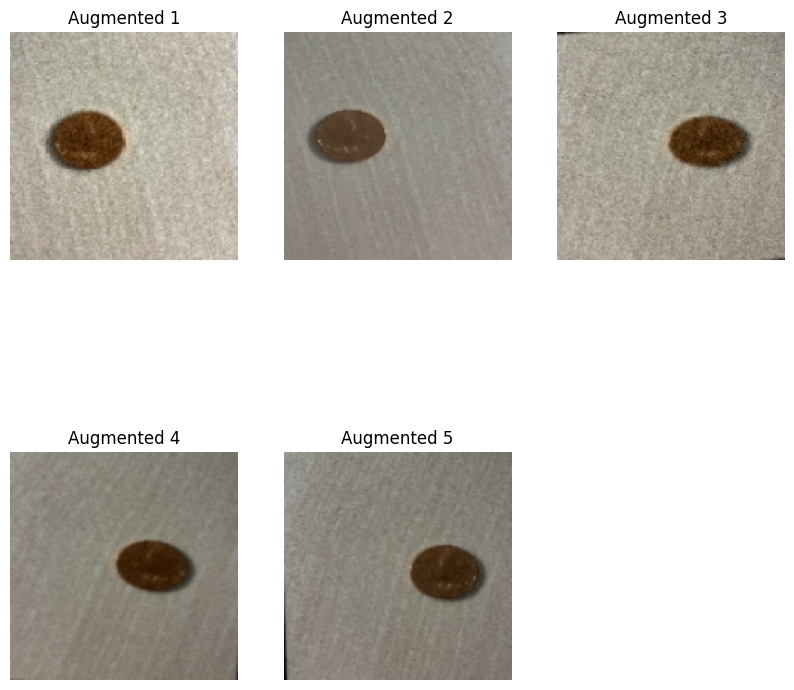

In [36]:
import imgaug.augmenters as iaa
import cv2

# Define augmentation pipeline
augmentation_pipeline = iaa.Sequential([
    iaa.Rotate((-10, 10)),          # Rotate images by -10 to 10 degrees
    iaa.Fliplr(0.5),                # Flip images horizontally with 50% probability
    iaa.GaussianBlur(sigma=(0, 1)), # Apply Gaussian blur with sigma ranging from 0 to 1
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Multiply((0.8, 1.2)),       # Multiply pixel values by a random value between 0.8 and 1.2
    iaa.ContrastNormalization((0.8, 1.2)),  # Normalize contrast
    iaa.Crop(px=(0, 16)),           # Crop images by up to 16 pixels
])

# Load and preprocess a single image using OpenCV
img_path = '/Users/yacineflici/Documents/master-vmi/s2/projet-money/IMAGE_JPEG/IMG_5960.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
img = cv2.resize(img, (150, 150))  # Resize image to desired dimensions

# Apply augmentation pipeline to the image
augmented_images = augmentation_pipeline(images=[img] * 5)  # Generate 5 augmented images

# Plot the original and augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_img)
    plt.axis('off')
    plt.title(f'Augmented {i + 1}')
plt.show()
